# An RNN model for temperature data
Multi-site model

In [1]:
import math
import sys
import numpy as np
import utils_batching
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


In [2]:
from matplotlib import pyplot as plt
from matplotlib import transforms as plttrans
import utils_prettystyle 

## Hyperparameters
N_FORWARD = 1: works but model struggles to predict from top of oscillation
N_FORWARD = 4: better but still bad from top of oscillation
N_FORWARD = 8: works perfectly 

In [3]:
NB_EPOCHS = 5       # number of times the model sees all the data during training

N_FORWARD = 8       # train the network to predict N in advance (traditionnally 1)
RESAMPLE_BY = 5     # averaging period in days (training on daily data is too much)
RNN_CELLSIZE = 128  # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 128        # unrolled sequence length
BATCHSIZE = 64      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)
ACTIVATION = tf.nn.tanh # Activation function for GRU cells (tf.nn.relu or tf.nn.tanh)

TRAIN_FILEPATTERN = "temperatures/USW*0.csv"  # pattern USW*.csv -> 298 files, pattern USW*0.csv -> 28 files
EVAL_FILEPATTERN = "temperatures/USC000????2.csv" # pattern matches 8 files
#TRAIN_FILEPATTERN = "gs://ml1-demo-martin/good_temperature_data/US*[!2].csv" #pattern matches 796 files  
#EVAL_FILEPATTERN = "gs://ml1-demo-martin/good_temperature_data/USC000????2.csv"

## Temperature data
This is what our temperature datasets looks like: sequences of daily (Tmin, Tmax) from 1960 to 2010. They have been cleaned up and eventual missing values have been filled by interpolation. Interpolated regions of the dataset are marked in red on the graph.

In [4]:
for evaltemps, _, vdates, _, _ in \
utils_batching.rnn_multistation_sampling_temperature_sequencer(EVAL_FILEPATTERN): break
print("eval_temperatures.shape: " + str(evaltemps.shape))

Pattern "temperatures/USC000????2.csv" matches 8 files
Loading 8 files........
eval_temperatures.shape: (8, 18262, 3)


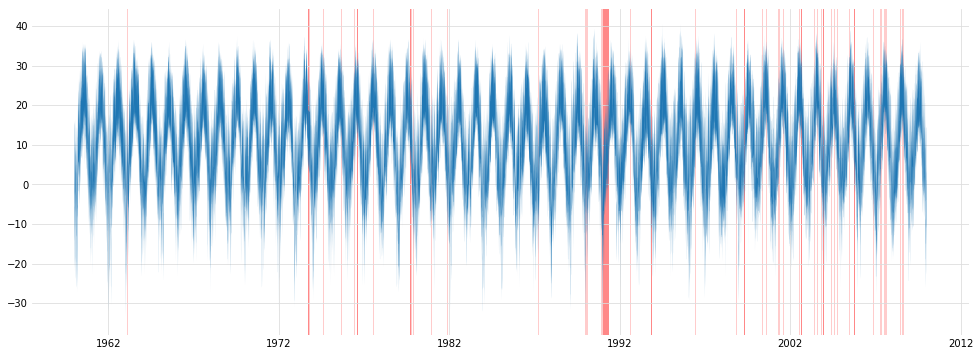

In [5]:
# You can adjust the visualisation range and dataset here. For example
# eval_temperatures[3, 15000:16000] to see eval datase #3 between 2001
# and 2003. Do not forget to change the dates range in the same way.
# Interpolated regions of the dataset are marked in red.
visu_temperatures = evaltemps[0]
visu_dates = vdates[:]

# TODO ----- move to utils file -----
min_temps = visu_temperatures[:,0]
max_temps = visu_temperatures[:,1]
interpolated = visu_temperatures[:,2]

interpolated_sequence = False
#plt.plot(dates, max_temps)
for i, date in enumerate(visu_dates):
    if interpolated[i]:
        if not interpolated_sequence:
            startdate = date
        interpolated_sequence = True
        stopdate=date
    else:
        if interpolated_sequence:
            # light shade of red just for visibility
            plt.axvspan(startdate+np.timedelta64(-5, 'D'), stopdate+np.timedelta64(6, 'D'), facecolor='#FFCCCC', alpha=1)
            # actual interpolated region
            plt.axvspan(startdate+np.timedelta64(-1, 'D'), stopdate+np.timedelta64(1, 'D'), facecolor='#FF8888', alpha=1)
        interpolated_sequence = False
plt.fill_between(visu_dates, min_temps, max_temps).set_zorder(10)
plt.show()

## Resampling
Our RNN would need ot be unrolled across 365 steps to capture the yearly temperature cycles. That's a bit too much. We will resample the temparatures and work with 5-day averages for example. This is what resampled (Tmin, Tmax) temperatures look like.

In [6]:
for evaltemps, _, evaldates, _, _ in \
utils_batching.rnn_multistation_sampling_temperature_sequencer(EVAL_FILEPATTERN, RESAMPLE_BY, tminmax=True): break

Pattern "temperatures/USC000????2.csv" matches 8 files
Loading 8 files........


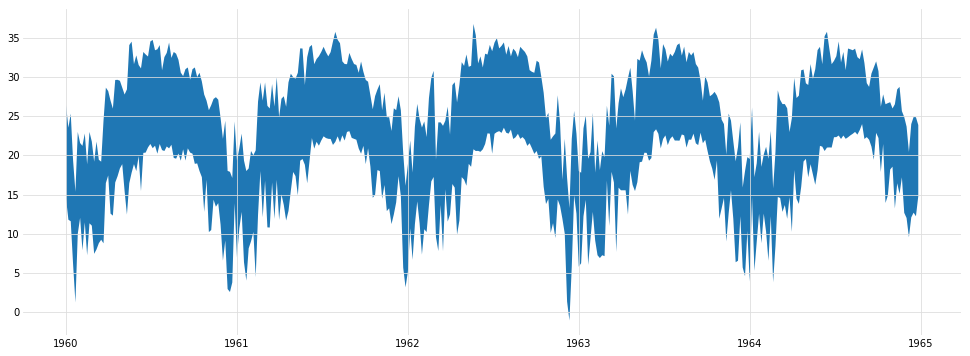

In [7]:
# display five years worth of data
DISPLEN = 365*5//RESAMPLE_BY # 5 years
visu_temperatures = evaltemps[0, :DISPLEN]
visu_dates = evaldates[:DISPLEN]
plt.fill_between(visu_dates, visu_temperatures[:,0], visu_temperatures[:,1])
plt.show()

## Visualize training sequences
This is what the neural network will see during training.

Pattern "temperatures/USC000????2.csv" matches 8 files
Loading 8 files........


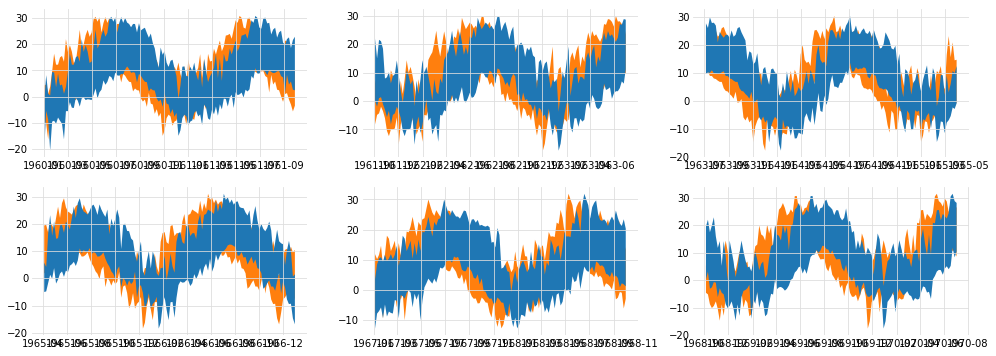

In [8]:
# The function rnn_multistation_sampling_temperature_sequencer puts one weather station per line in
# a batch and continues with data from the same station in corresponding lines in the next batch.
# Samples and targets are returned with shapes [BATCHSIZE, SEQLEN, 2]. The last dimension of size 2
# contains (Tmin, Tmax).
subplot = 231
for samples, targets, dates, _, _ in utils_batching.rnn_multistation_sampling_temperature_sequencer(EVAL_FILEPATTERN,
                                                        RESAMPLE_BY, BATCHSIZE, SEQLEN, N_FORWARD, 1, tminmax=True):
    plt.subplot(subplot)
    plt.fill_between(dates, samples[0,:,0], samples[0,:,1])
    plt.fill_between(dates, targets[0,:,0], targets[0,:,1]).set_zorder(-1)
    subplot += 1
    if subplot==237: break
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [9]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    pairlen = tf.shape(X)[2] # should be 2 (tmin, tmax)
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE, activation=ACTIVATION) for _ in range(NLAYERS)]
    # dropout useful between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 2], Hin[BATCHSIZE, RNN_CELLSIZE*NLAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin, dtype=tf.float32)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 2) # Yr [BATCHSIZE*SEQLEN, 2]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 2]) # Yr [BATCHSIZE, SEQLEN, 2]
    Yout = Yr[:,-N_FORWARD:,:] # Last N_FORWARD outputs Yout [BATCHSIZE, N_FORWARD, 2]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 2]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op, Yr

## Instantiate the model

In [10]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 2]) # [BATCHSIZE, SEQLEN, 2]
labels = tf.placeholder(tf.float32, [None, None, 2]) # [BATCHSIZE, SEQLEN, 2]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op, Yr = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [11]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS]) # zero state initially
    Yout_ = np.zeros([1, N_FORWARD, 2])
    data_len = prime_data.shape[0]-N_FORWARD

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data[:-N_FORWARD])
        Yin = np.reshape(Yin, [1, data_len, 2]) # reshape as one sequence of pairs (tmin, tmax)
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        
        # initaiily, put real data on the inputs, not predictions
        Yout_ = np.expand_dims(prime_data[-N_FORWARD:], axis=0)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length//N_FORWARD):
        #Yout_ = np.reshape(Yout_, [1, N_FORWARD, 2]) # batch of a single sequence of a single vector (tmin, tmax)
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed) # Yout_ shape [1,2]
        results.append(Yout_[0]) # shape [N_FORWARD, 2]
        
    return np.concatenate(results, axis=0)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [12]:
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

In [13]:
#NB_EPOCHS = 20

losses = []
indices = []
last_epoch = 999
last_fileid = 999
for i, (next_samples, next_targets, dates, epoch, fileid) in enumerate(
    utils_batching.rnn_multistation_sampling_temperature_sequencer(TRAIN_FILEPATTERN,
                                                                   RESAMPLE_BY,
                                                                   BATCHSIZE,
                                                                   SEQLEN,
                                                                   N_FORWARD,
                                                                   NB_EPOCHS, tminmax=True)):
    
    # reinintialize state between epochs
    if epoch != last_epoch or fileid != last_fileid:
        batchsize = next_samples.shape[0]
        H_ = np.zeros([batchsize, RNN_CELLSIZE * NLAYERS])
        print("State reset")

    #train
    feed = {Hin: H_, samples: next_samples, labels: next_targets, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _, Yr_ = sess.run([Yout, H, loss, train_op, Yr], feed_dict=feed)
    
    # print progress
    if i%20 == 0:
        print("{}: epoch {} loss = {} ({} weather stations this epoch)".format(i, epoch, np.mean(loss_), fileid+1))
        sys.stdout.flush()
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)
    # This visualisation can be helpful to see how the model "locks" on the shape of the curve
#    if i%100 == 0:
#        plt.figure(figsize=(10,2))
#        plt.fill_between(dates, next_samples[0,:,0], next_samples[0,:,1]).set_alpha(0.2)
#        plt.fill_between(dates, next_targets[0,:,0], next_targets[0,:,1])
#        plt.fill_between(dates, Yr_[0,:,0], Yr_[0,:,1]).set_alpha(0.8)
#        plt.show()
        
    last_epoch = epoch
    last_fileid = fileid

Pattern "temperatures/USW*0.csv" matches 28 files
Loading 28 files............................
State reset
0: epoch 0 loss = 318.12847900390625 (28 weather stations this epoch)
20: epoch 0 loss = 35.838993072509766 (28 weather stations this epoch)
State reset
40: epoch 1 loss = 20.295490264892578 (28 weather stations this epoch)
State reset
60: epoch 2 loss = 19.40471076965332 (28 weather stations this epoch)
80: epoch 2 loss = 21.33926010131836 (28 weather stations this epoch)
State reset
100: epoch 3 loss = 19.32646369934082 (28 weather stations this epoch)
State reset
120: epoch 4 loss = 18.573801040649414 (28 weather stations this epoch)


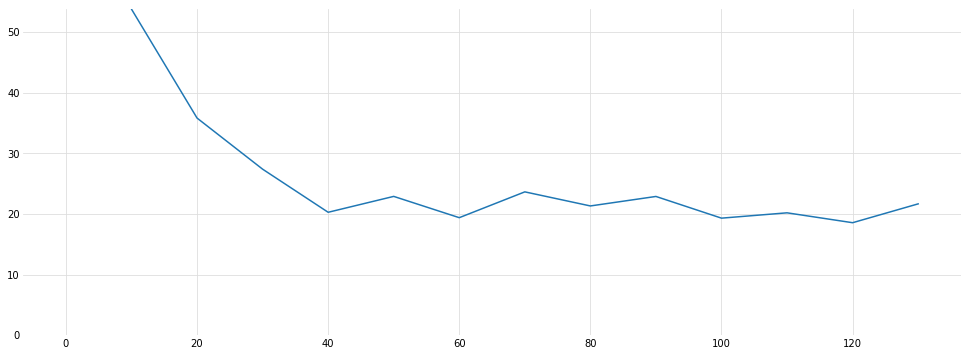

In [14]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

In [15]:


# TODO: it works
# move visu code elsewhere
# !!! train on GPU ?
# have a smaller set of eval files (3 to 5 ideally)

## Validation

In [16]:
QYEAR = 365//(RESAMPLE_BY*4)
YEAR = 365//(RESAMPLE_BY)
# Try starting predictions from January / March / July (resp. OFFSET = YEAR or YEAR+QYEAR or YEAR+2*QYEAR)
# Some start dates are more challenging for the model that others.
OFFSET = YEAR+1*QYEAR
RMSELEN=3*365//(RESAMPLE_BY*2) # accuracy of predictions 1.5 years in advance
PRIMELEN=512
RUNLEN=256

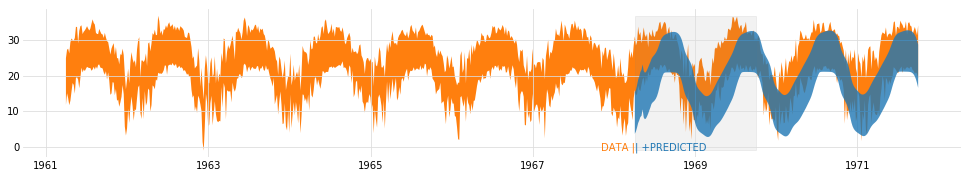

RMSE on 109 predictions (shaded area): 6.641576852663239


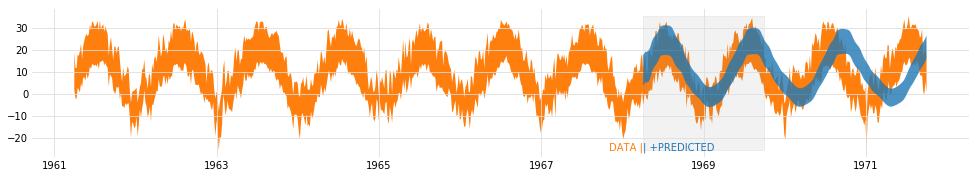

RMSE on 109 predictions (shaded area): 5.36178404857496


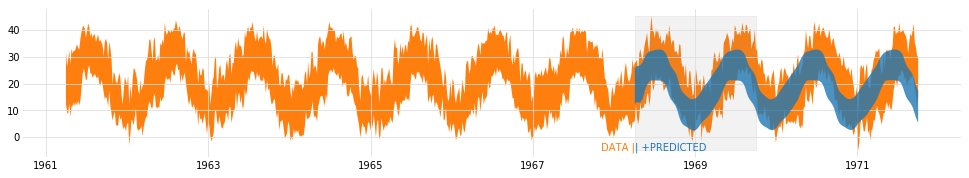

RMSE on 109 predictions (shaded area): 6.209209504331604


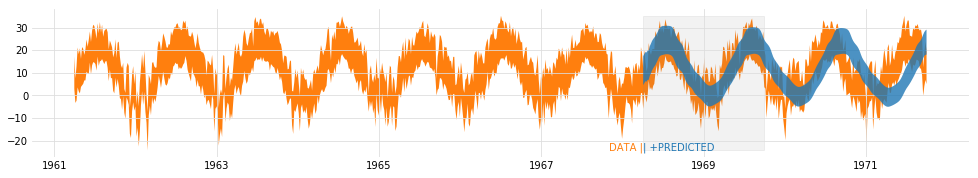

RMSE on 109 predictions (shaded area): 4.811182599678563


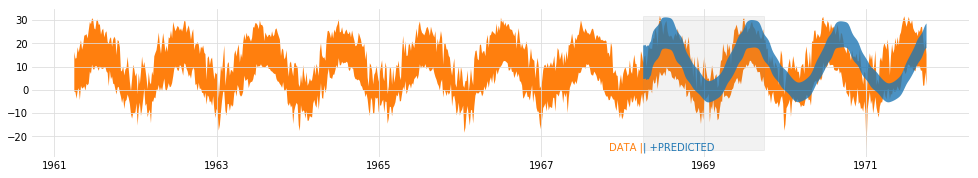

RMSE on 109 predictions (shaded area): 6.232408120153448


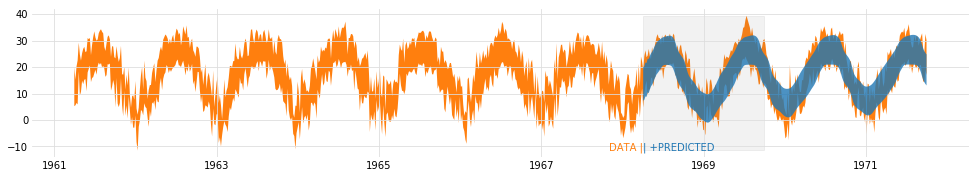

RMSE on 109 predictions (shaded area): 2.8899236100708254


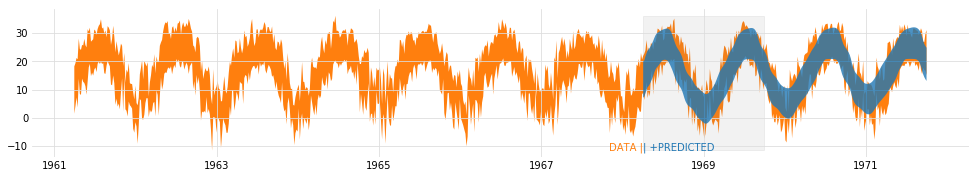

RMSE on 109 predictions (shaded area): 3.5537300470062827


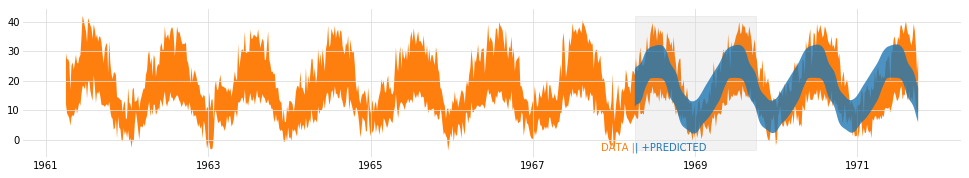

RMSE on 109 predictions (shaded area): 4.657463233912323


In [17]:
for evaldata in evaltemps:
    prime_data = evaldata[OFFSET:OFFSET+PRIMELEN]
    results = prediction_run(prime_data, RUNLEN)
    #print(results.shape)

    disp_data = evaldata[OFFSET:OFFSET+PRIMELEN+RUNLEN]
    disp_dates = evaldates[OFFSET:OFFSET+PRIMELEN+RUNLEN]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #sp = plt.subplot(211)
    #trans = plttrans.blended_transform_factory(sp.transData, sp.transAxes)
    #plt.text(disp_dates[PRIMELEN],0.05,"DATA |", color=colors[1], horizontalalignment="right", transform=trans)
    #plt.text(disp_dates[PRIMELEN],0.05,"| +PREDICTED", color=colors[0], horizontalalignment="left", transform=trans)
    displayresults = np.ma.array(np.concatenate((np.zeros([PRIMELEN,2]), results)))
    displayresults = np.ma.masked_where(displayresults == 0, displayresults)
    #plt.fill_between(disp_dates, displayresults[:,0], displayresults[:,1]).set_alpha(0.8)
    #displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([RUNLEN,2]))))
    #displaydata = np.ma.masked_where(displaydata == 0, displaydata)
    #plt.fill_between(disp_dates, displaydata[:,0], displaydata[:,1])
    sp = plt.subplot(212)
    p = plt.fill_between(disp_dates, displayresults[:,0], displayresults[:,1])
    p.set_alpha(0.8)
    p.set_zorder(10)
    trans = plttrans.blended_transform_factory(sp.transData, sp.transAxes)
    plt.text(disp_dates[PRIMELEN],0.05,"DATA |", color=colors[1], horizontalalignment="right", transform=trans)
    plt.text(disp_dates[PRIMELEN],0.05,"| +PREDICTED", color=colors[0], horizontalalignment="left", transform=trans)
    plt.fill_between(disp_dates, disp_data[:,0], disp_data[:,1])
    plt.axvspan(disp_dates[PRIMELEN], disp_dates[PRIMELEN+RMSELEN], color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
    plt.show()
    
    rmse = math.sqrt(np.mean((evaldata[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
    print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))
    sys.stdout.flush()

In [18]:
rmses = []
bad_ones = 0
for offset in [YEAR, YEAR+QYEAR, YEAR+2*QYEAR]:
    for evaldata in evaltemps:
        prime_data = evaldata[offset:offset+PRIMELEN]
        results = prediction_run(prime_data, RUNLEN)
        rmse = math.sqrt(np.mean((evaldata[offset+PRIMELEN:offset+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
        rmses.append(rmse)
        if rmse>7: bad_ones += 1
        print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))
print("Average RMSE on {} weather stations: {} ({} really bad ones, i.e. >7.0)".format(len(evaltemps), np.mean(rmses), bad_ones))
sys.stdout.flush()

RMSE on 109 predictions (shaded area): 6.551521714041942
RMSE on 109 predictions (shaded area): 4.686446756228263
RMSE on 109 predictions (shaded area): 5.213207304714624
RMSE on 109 predictions (shaded area): 4.8314162765283575
RMSE on 109 predictions (shaded area): 6.08613076349357
RMSE on 109 predictions (shaded area): 3.370798538089162
RMSE on 109 predictions (shaded area): 4.545247022174015
RMSE on 109 predictions (shaded area): 3.9715551821250266
RMSE on 109 predictions (shaded area): 6.641576852663239
RMSE on 109 predictions (shaded area): 5.36178404857496
RMSE on 109 predictions (shaded area): 6.209209504331604
RMSE on 109 predictions (shaded area): 4.811182599678563
RMSE on 109 predictions (shaded area): 6.232408120153448
RMSE on 109 predictions (shaded area): 2.8899236100708254
RMSE on 109 predictions (shaded area): 3.5537300470062827
RMSE on 109 predictions (shaded area): 4.657463233912323
RMSE on 109 predictions (shaded area): 7.416335273716704
RMSE on 109 predictions (shad

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.